In [1]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import HTML
HTML("<style>.container { width: 90% !important; }</style>")

In [2]:
import utils

import sneks
import gym

from tqdm.notebook import trange
import numpy as np
import torch
import torch.nn as nn

utils.info

{'torch_version': '1.3.1', 'torch_device': 'cuda', 'gym_version': '0.17.1'}

In [3]:
# utils.use_virtual_display()

In [4]:
env_name = 'CubeCrash-v0'

In [5]:
# env = gym.make('snek-rgb-16-v1')
env = gym.make(env_name)

observation = env.reset()
action = env.action_space.sample()
observation, reward, done, info = env.step(action)

num_actions = env.action_space.n
obs_size = np.prod(env.observation_space.shape)

obs_size, num_actions, env.reward_range, # env.unwrapped.unwrapped.get_action_meanings()

(3840, 3, (-inf, inf))

In [6]:
dqn = utils.DQNAgent(obs_size, num_actions)
dqn.make_persisted(f'./.models/{env_name}_dqn.pkl')

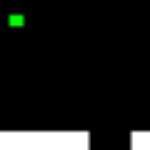

In [7]:
dqn_play_env = utils.play_env(env, dqn, duration=100)
utils.i_python_display_frames(dqn_play_env, fps=60, frame_size=(150, 150))

In [8]:
generator = utils.ExperienceGenerator(env, dqn, bs=100)
next(generator)
batch = next(generator)
{
    k: dict(shape=t.shape, max=t.max(), min=t.min()) 
    for k, t in batch.items()
}

{'obs': {'shape': (100, 40, 32, 3), 'max': 1.0, 'min': 0.0},
 'actions': {'shape': (100,), 'max': 2, 'min': 0},
 'rewards': {'shape': (100,), 'max': 0.01, 'min': -1.0},
 'next_obs': {'shape': (100, 40, 32, 3), 'max': 1.0, 'min': 0.0},
 'done': {'shape': (100,), 'max': True, 'min': False}}

In [9]:
generator.episodes_len

[31, 28, 30, 12]

<IPython.core.display.Javascript object>


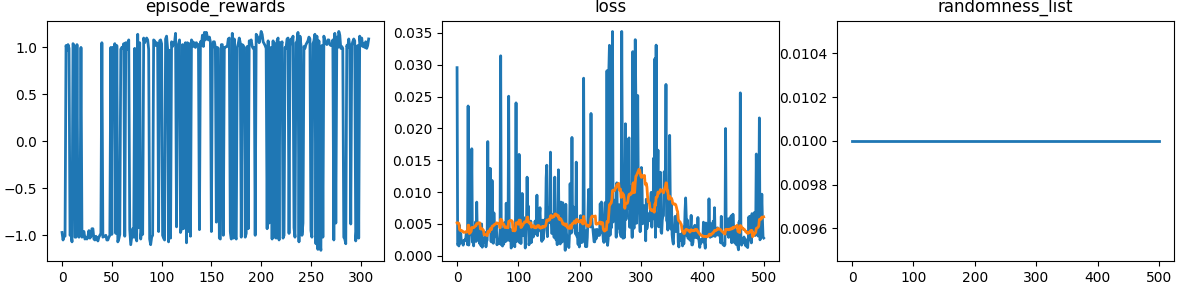

In [10]:
train_exp_generator = utils.ExperienceGenerator(env, dqn, bs=128)

def train():
    %matplotlib notebook
    its = 10_000

    optimize = dqn.optimizer(train_exp_generator, lr=0.001)
    plotter = utils.Plotter()

    tr = trange(its, bar_format="{bar}{l_bar}{r_bar}")
    for i in tr:
        info = next(optimize)
        plotter.log(**info)
        plotter.log(episode_rewards=train_exp_generator.episode_rewards[:-1])
        plotter.log(randomness_list=train_exp_generator.randomness_list)

        tr.set_description(' | '.join([
            'LOSS: %.6f' % info['loss'],
            'EP REWARD: %.2f' % np.mean(train_exp_generator.episode_rewards[-5:-1]),
        ]))

        if i % 200 == 0: plotter.plot()


# if dqn.can_be_preloaded():
#     print('Loading pretrained model')
#     dqn.load_persisted_if_exists()
# else:
#     print('No pretrained model found. Training...')
#     train()
#     dqn.persist()

train()
dqn.persist()

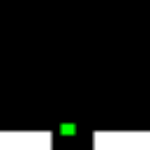

In [11]:
utils.i_python_display_frames(frames=utils.play_env(env, dqn, duration=200), fps=60, frame_size=(150, 150))

In [12]:
def randomly_good_agent(obs):
    if np.random.uniform() < 0.5:
        return env.action_space.sample()
    else:
        return dqn(obs)

In [13]:
# def render_rollout():
#     gen = utils.RolloutGenerator(env, agent=randomly_good_agent, bs=16, max_seq_len=20, buffer_size=50, frame_size=(100, 100))
#     i = 100

#     for ep_id, actions, observations, renders_batch in gen:
#         for renders in renders_batch:
#             for r in renders:
#                 i -= 1
#                 if i <= 0: return

#                 yield r
                
# utils.i_python_display_frames(render_rollout(), fps=30)

g = utils.RolloutGenerator(
    env,
    agent=randomly_good_agent,
    bs=16,
    max_seq_len=32,
    buffer_size=50,
    frame_size=(32, 32)
)

batch = next(g)
utils.batch_info(batch)

{'ep_id': {'shape': (16,), 'max': 15, 'min': 0},
 'actions': {'shape': (16, 32), 'max': 2.0, 'min': 0.0},
 'obs': {'shape': (16, 32, 40, 32, 3), 'max': 255.0, 'min': 0.0},
 'frames': {'shape': (16, 32, 32, 32, 3), 'max': 255.0, 'min': 0.0}}

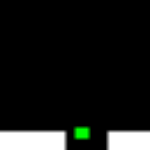

In [14]:
utils.i_python_display_frames(frames=batch['obs'][0], fps=100, frame_size=(150, 150))

In [15]:
num_rollouts = 1000
seq_len = 32
frame_size = (32, 32)
num_actions = env.action_space.n

world_model = utils.RNNWorldRepresentations((*frame_size, 3), num_actions, seq_len, num_rollouts)
world_model.make_persisted(f'./.models/{env_name}_world_model.pkl')
# world_model.load_persisted_if_exists()
world_model

RNNWorldRepresentations(
  (precondition): Embedding(1000, 32)
  (action_encoder): Sequential(
    (0): Linear(in_features=3, out_features=16, bias=True)
    (1): Tanh()
  )
  (time_transition): GRU(16, 16, num_layers=2, batch_first=True)
  (obs_decoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=16, out_features=128, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=128, out_features=3072, bias=True)
      (1): Sigmoid()
    )
    (3): Lambda()
  )
)

In [16]:
training_generator = utils.RolloutGenerator(
    env,
    agent=randomly_good_agent,
    bs=16,
    max_seq_len=seq_len,
    buffer_size=num_rollouts,
    frame_size=frame_size,
)

def next_preprocessed_batch():
    for batch in training_generator:
        ep_id, actions, observations, frames = \
            [batch[k] for k in ['ep_id', 'actions', 'obs', 'frames']]

        frames = frames / 255
        actions = utils.one_hot(actions.astype(np.int32))
        yield (ep_id, actions), frames

<IPython.core.display.Javascript object>


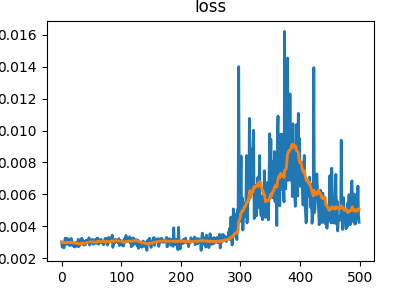

In [17]:
%matplotlib notebook
its = 50_000

next_batch = next_preprocessed_batch()
optimize = world_model.optimizer(next_batch, lr=0.001)
plotter = utils.Plotter()

tr = trange(its, bar_format="{bar}{l_bar}{r_bar}")
for i in tr:
    info = next(optimize)
    plotter.log(**info)

    tr.set_description(' | '.join([
        'LOSS: %.6f' % info['loss'],
        'BUFFER SIZE: %i' % len(training_generator.buffer),
        'AVG EPISODE LEN: %i' % np.mean(training_generator.episodes_len[:-50] + [0]),
    ]))

    if i % 50 == 0: plotter.plot()

In [18]:
world_model.persist()

In [19]:
len(training_generator.buffer)

1000

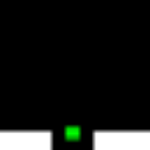

In [23]:
ep_id, actions, observations, frames = training_generator.buffer[1]
utils.i_python_display_frames(frames=frames, fps=20, frame_size=(150, 150))

In [21]:
import cv2

In [24]:
def multiple_games_generator():
    rollouts = training_generator.buffer[:10]
    for ep_id, actions, observations, frames in rollouts:
        pred_frames = world_model(
            [ep_id], [utils.one_hot(actions.astype(np.int32))]
        ).detach().cpu().numpy()[0] * 255

        for final_frame in utils.tile_frame_generators(frames, pred_frames):
            final_frame = cv2.resize(final_frame, (401, 200))
            font = cv2.FONT_HERSHEY_SIMPLEX
            cv2.putText(final_frame, f'ep:{ep_id + 1}', (5, 20), font, 0.7, (0, 255, 0), 2, cv2.LINE_AA)
            yield final_frame


vid_path = '.videos/rnn_rollour.webm'
utils.frames_to_video(name=vid_path, frames=multiple_games_generator(), fps=10)
utils.display_video(vid_path)